<h1><center>Predicting Outcomes of Kickstarter Campaigns</center></h1>

Vaibhav Menon (A12250311): Data cleaning, first part of data analysis and related written sections, data visualization and related written sections

Sahej Randhawa (A12421083): Data cleaning, second (classification model part of data analysis, beginning and ending written sections

Gurjeet Chahal (A12014863): Data visualization

<h2><center>Introduction and Background</center></h2>


In the past decade, crowdfunding has grown into a significant form of providing and receiving investment and funding, connecting a global community of potential patrons to a broad spectrum of projects and initiatives. In 2015, crowdfunding was estimated to have resulted in over $34 billion in investment, more than the average annual total investment by the venture capital industry (Barnett). 

One of the foremost crowdfunding sites is Kickstarter, with over 140,000 successfully funded projects and a total of over 3.5 billion dollars pledged toward projects ("Kickstarter Stats"). While these figures clearly indicate that Kickstarter is an effective medium for collecting funds to drive project completion, 14 percent of projects never see a single pledge and more than 400 million dollars is left on the table--money not used toward projects that had unsuccessful funding campaigns. This is a result of Kickstarter's all-or-nothing model: if a goal is not met, no money is exchanged between donors and recipient. Identifying factors that prompt donors to pledge towards a project can provide insight into accurately predicting the outcomes of Kickstarter campaigns. For example, Kickstarter's published statistics updated daily indicate that projects categorized under dance, theater, comics, and games possess the highest success rates while technology, food, and journalism projects struggle to see fruition. Isolating features like this to distinguish these different projects is crucial to successful prediction. 

### Research Question

Thus, we seek to understand what properties of a Kickstarter campaign determine if it succeeds or fails in reaching its funding goal, motivating our research question: Which features of a Kickstarter campaign are the strongest indicators of campaign success? Furthermore, can these features be used to predict success or failure better than baselines that are naive or randomly based?

### Related Research

Previous projects have attempted to answer similar questions. One study used natural language processing to assign valence to words and phrases within Kickstarter project descriptions (Tanushree and Gilbert). This can identify for vendors how to frame their project most persuasively. However, the methodology of this study kept other variables such as campaign category, goal, and duration as controls. The fact that they identified other potential variables but chose to hold them constant to hone analysis on language suggests that these other attributes could have influence on campaign outcomes and are worth observing.

### Hypothesis

We project that the essential factors in determining success are the campaign’s category, amount of funding set as its goal, duration of time the campaign is open for, whether the campaign was selected as a “staff pick,” and the words chosen in the campaign blurb to set apart this product from others in its category. We believe this is so because these features reflect either attractiveness of the campaign to Kickstarter’s base of users or feasibility of the fundraising goal. Furthermore, we believe that using these properties of a campaign to form features and train a classifier on will yield predictions of a campaign’s success or failure better than naive baselines, such as randomly choosing success/failure based on the total proportion of successful/failed projects on Kickstarter.

<h2><center>Data Description</center></h2>

The data that we will be using was obtained from a third-party company that develops web scraping platforms and openly publishes the data from scraping all Kickstarter campaign every month (found here: https://webrobots.io/kickstarter-datasets/). We are using their 2018-01-12 version of their data. It includes 37 columns, including the campaign’s name, id, category, blurb used to describe it, funding goal, launch and end times, whether it was selected as a “staff pick,” location (city, state, and country level), user profile, number of backers, amount raised, and whether the campaign was successful in reaching its fundraising goal or not. Times are stored in Unix time and many other categories are stored as string representations of URLs or json objects containing URLs, as this data merely contains the results of the web scraper--raw information as it is stored and represnted on the webpage.

This data is split among 49 .csv files but reports the same information for each campaign. Thus, we suspect that we need to merely concatenate these files and remove potential duplicates by campaign id to combine them into a single dataset.

More information on the actual columns is provided in the Data Visualiation and Data Analysis sections below.

<h2><center>Data Cleaning and Preprocessing</center></h2>

In [150]:
# Imports - these are all the imports needed for the assignment
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import random

# Import nltk package 
#   PennTreeBank word tokenizer 
#   English language stopwords
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# scikit and scipy imports
import sklearn.svm as svm
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import classification_report, precision_recall_fscore_support
from scipy.stats import ttest_ind, chisquare, normaltest, f_oneway
import scipy.stats as stats
import seaborn as sns

#for whitening data
from scipy.cluster.vq import whiten


Because we were using 49 datasets–all with the same information–we needed to first concatenate them into a single dataframe. This data frame, with over 200,000 entries needed to be cleaned and wrangled before any meaningful analysis could be performed on it. Cleaning the data involved getting rid of duplicate entries, entries with missing data in meaningful fields, dropping unnecessary columns, and extracting information from messy entries. For example, the raw, scraped data for category and location both are in the form of long urls, with only specific parts within that long string that correspond to the information we want. Thus we, wrote simple extraction functions to handle these cases to extract campaign category classification and location information.

Additionally, to do meaningful analysis based on time, we needed to convert the times provided in the original dataset from unix times to standard times. However, for the classifier we built for prediction modeling, the unix times were better suited for analysis. 

In [2]:
# Import data
numFiles = 49
path = '../rawData011218/' #Change this based on personal file location
fileStem = 'Kickstarter'
fileList = []
for i in range(numFiles):
    if i == 0:
        fileName = path+fileStem+'.csv'
    elif i < 10:
        fileName = path+fileStem+'00'+str(i)+'.csv'
    else:
        fileName = path+fileStem+'0'+str(i)+'.csv'
    dataframe = pd.read_csv(fileName)
    fileList.append(dataframe)

In [153]:
#Concatenating all 49 .csv files into one dataframe
ksAll_df = pd.concat(fileList,ignore_index=True)
sumLen = 0
for i in range(len(fileList)):
    #print(fileList[i].shape,end=' ')
    sumLen += fileList[i].shape[0]
#print()
print("Total Rows:",sumLen)

Total Rows: 196792


In [154]:
#Dropping all duplicate projects in df by 'id'
ksAll_unique_df=ksAll_df.drop_duplicates('id', inplace=False)
ksAll_unique_df.head()

,backers_count,blurb,category,converted_pledged_amount,country,created_at,creator,currency,currency_symbol,currency_trailing_code,...,state_changed_at,static_usd_rate,urls,usd_pledged,usd_type,location,friends,is_backing,is_starred,permissions
0,1,"Monsters, Fantasy, Illusion, Delusion, and a h...","{""urls"":{""web"":{""discover"":""http://www.kicksta...",20,US,1332493397,"{""urls"":{""web"":{""user"":""https://www.kickstarte...",USD,$,True,...,1336447572,1.0,"{""web"":{""project"":""https://www.kickstarter.com...",20.0,domestic,"{""country"":""US"",""urls"":{""web"":{""discover"":""htt...",NaN,NaN,NaN,NaN
1,37,Nano Art will make and market customized piece...,"{""urls"":{""web"":{""discover"":""http://www.kicksta...",1974,US,1332823105,"{""urls"":{""web"":{""user"":""https://www.kickstarte...",USD,$,True,...,1337287105,1.0,"{""web"":{""project"":""https://www.kickstarter.com...",1974.0,domestic,"{""country"":""US"",""urls"":{""web"":{""discover"":""htt...",NaN,NaN,NaN,NaN
2,81,Video and audio coverage of the MUTEK festival...,"{""urls"":{""web"":{""discover"":""http://www.kicksta...",4845,US,1331241234,"{""urls"":{""web"":{""user"":""https://www.kickstarte...",USD,$,True,...,1337227140,1.0,"{""web"":{""project"":""https://www.kickstarter.com...",4845.0,domestic,"{""country"":""CA"",""urls"":{""web"":{""discover"":""htt...",NaN,NaN,NaN,NaN
3,95,"Finally, A Storyboard App Done Right!","{""urls"":{""web"":{""discover"":""http://www.kicksta...",2948,US,1332350493,"{""urls"":{""web"":{""user"":""https://www.kickstarte...",USD,$,True,...,1338448438,1.0,"{""web"":{""project"":""https://www.kickstarter.com...",2948.0,domestic,"{""country"":""US"",""urls"":{""web"":{""discover"":""htt...",NaN,NaN,NaN,NaN
4,10,"If you like books and bookmarks, stick these s...","{""urls"":{""web"":{""discover"":""http://www.kicksta...",522,US,1333768943,"{""urls"":{""web"":{""user"":""https://www.kickstarte...",USD,$,True,...,1338609542,1.0,"{""web"":{""project"":""https://www.kickstarter.com...",522.0,domestic,"{""country"":""US"",""urls"":{""web"":{""discover"":""htt...",NaN,NaN,NaN,NaN


In [155]:
#Creating a function for extracting category- The provided json locations (which category a campaign is located) of 
#the campaign is raw, messy data. To provide an understandable categorization, this function parses the string to
#provide a manageable output.
    #Input:
        #category is a string that corresponds to the json location of the campaign (category-wise).
    #Output:
        #Output is in format of 'category/subcategory'
def extract_category(url):
    start=url.find('/categories/')+12
    end=url.find('"}}')
    category=url[start:end]
    space='%20'
    category=category.replace(space, ' ')   
    return(category)
#test to ensure function works correctly
extract_category('{"urls":{"web":{"discover":"http://www.kickstarter.com/discover/categories/theater/plays"}},"color":16743775,"parent_id":17,"name":"Plays","id":285,"position":6,"slug":"theater/plays"}')

stringtest="theater/plays"
def extract_category_general(url):
    #start=url.find('/categories/')+12
    end=url.find('/')
    category=url[:end]   
    return(category)
extract_category_general(stringtest)

'theater'

In [156]:
#Extracting category from each campaign
ksAll_unique_df['category']=ksAll_unique_df['category'].apply(extract_category)

In [157]:
#create column for specific cateogires
ksAll_unique_df['gencat']=ksAll_unique_df['category'].apply(extract_category_general)
ksAll_unique_df['gencat'].value_counts()

#extraction cut off some category names by a single letter, manually handling that
def complete_food (cat):
    if cat == 'foo':
        cat = 'food'
        return (cat)
    else:
        return (cat)
ksAll_unique_df['gencat'] = ksAll_unique_df['gencat'].apply(complete_food)

def complete_music (cat):
    if cat == 'musi':
        cat = 'music'
        return (cat)
    else:
        return (cat)
ksAll_unique_df['gencat'] = ksAll_unique_df['gencat'].apply(complete_music)

def complete_theater (cat):
    if cat == 'theate':
        cat = 'theater'
        return (cat)
    else:
        return (cat)
ksAll_unique_df['gencat'] = ksAll_unique_df['gencat'].apply(complete_theater)

def complete_film_video (cat):
    if cat == 'film & vide':
        cat = 'film & video'
        return (cat)
    else:
        return (cat)
ksAll_unique_df['gencat'] = ksAll_unique_df['gencat'].apply(complete_film_video)

def complete_fashion (cat):
    if cat == 'fashio':
        cat = 'fashion'
        return (cat)
    else:
        return (cat)
ksAll_unique_df['gencat'] = ksAll_unique_df['gencat'].apply(complete_fashion)

def complete_photo (cat):
    if cat == 'photograph':
        cat = 'photography'
        return (cat)
    else:
        return (cat)
ksAll_unique_df['gencat'] = ksAll_unique_df['gencat'].apply(complete_photo)

def complete_dance (cat):
    if cat == 'danc':
        cat = 'dance'
        return (cat)
    else:
        return (cat)
ksAll_unique_df['gencat'] = ksAll_unique_df['gencat'].apply(complete_dance)

def complete_craft (cat):
    if cat == 'craft':
        cat = 'crafts'
        return (cat)
    else:
        return (cat)
ksAll_unique_df['gencat'] = ksAll_unique_df['gencat'].apply(complete_craft)

def complete_journalism(cat):
    if cat == 'journalis':
        cat = 'journalism'
        return (cat)
    else:
        return (cat)
ksAll_unique_df['gencat'] = ksAll_unique_df['gencat'].apply(complete_journalism)

def complete_art (cat):
    if cat == 'ar':
        cat = 'art'
        return (cat)
    else:
        return (cat)
ksAll_unique_df['gencat'] = ksAll_unique_df['gencat'].apply(complete_art)

def complete_game (cat):
    if cat == 'game':
        cat = 'games'
        return (cat)
    else:
        return (cat)
ksAll_unique_df['gencat'] = ksAll_unique_df['gencat'].apply(complete_game)

def complete_tech (cat):
    if cat == 'technolog':
        cat = 'technology'
        return (cat)
    else:
        return (cat)
ksAll_unique_df['gencat'] = ksAll_unique_df['gencat'].apply(complete_tech)

def complete_design (cat):
    if cat == 'desig':
        cat = 'design'
        return (cat)
    else:
        return (cat)
ksAll_unique_df['gencat'] = ksAll_unique_df['gencat'].apply(complete_design)

def complete_comics (cat):
    if cat == 'comic':
        cat = 'comics'
        return (cat)
    else:
        return (cat)
ksAll_unique_df['gencat'] = ksAll_unique_df['gencat'].apply(complete_comics)

def complete_publish (cat):
    if cat == 'publishin':
        cat = 'publishing'
        return (cat)
    else:
        return (cat)
ksAll_unique_df['gencat'] = ksAll_unique_df['gencat'].apply(complete_publish)

ksAll_unique_df['gencat'].value_counts()

music           24643
film & video    24014
technology      18429
art             17921
publishing      16990
food            14899
games           11418
fashion         10522
comics           7471
photography      6757
design           6342
theater          6204
crafts           5554
journalism       4252
dance            3042
Name: gencat, dtype: int64

Above we see the number of campaigns per each category, with music being the most popular and dance being the least.

In [158]:
#Dropping unnecessary columns in dataframe
colToDrop = ['currency_symbol','currency_trailing_code','current_currency','photo','profile','source_url',
             'permissions','is_starred','is_backing','friends', 'slug','disable_communication', 'id',
             'urls', 'usd_type','creator','converted_pledged_amount',]
ksAll_unique_df = ksAll_unique_df.drop(labels=colToDrop, axis=1)

After manually looking at the data and their corresponding webpages on Kickstarter, we noticed cases where the goal was not in US Dollars. Thus, we used the datasets given exchange rate and foreign goal amount to create a goal amount in USD so we could compare against the given pledged_usd column.

In [159]:
ksAll_unique_df["goal_usd"]=ksAll_unique_df["goal"]*ksAll_unique_df['static_usd_rate']

In [161]:
#function to return readable time from unix time input
def convert_time (unix):
    value = datetime.datetime.fromtimestamp(unix)
    value=value.strftime('%m-%d-%Y %H:%M:%S')
    return(value)
convert_time(1351123113)
def convert_time_year (unix):
    value = datetime.datetime.fromtimestamp(unix)
    value=value.strftime('%Y')
    return(value)
convert_time_year(1351123113)

'2012'

In [162]:
#applying convert_time to unix time columns in df
ksAll_unique_df['std_created_at']=ksAll_unique_df['created_at'].apply(convert_time)
ksAll_unique_df['std_launched_at']=ksAll_unique_df['launched_at'].apply(convert_time)
ksAll_unique_df['std_state_changed_at']=ksAll_unique_df['state_changed_at'].apply(convert_time)
ksAll_unique_df['std_deadline']=ksAll_unique_df['deadline'].apply(convert_time)
#ksAll_unique_df

Below we remove rows with NA values that would make analysis hard and see how many rows and columns we are left with.

In [164]:
#Drop entries where there are any missing values
ksAll_unique_df.dropna(inplace=True)
ksAll_unique_df.shape

(177499, 26)

In [165]:
ksAll_unique_df.columns

Index(['backers_count', 'blurb', 'category', 'country', 'created_at',
       'currency', 'deadline', 'fx_rate', 'goal', 'is_starrable',
       'launched_at', 'name', 'pledged', 'spotlight', 'staff_pick', 'state',
       'state_changed_at', 'static_usd_rate', 'usd_pledged', 'location',
       'gencat', 'goal_usd', 'std_created_at', 'std_launched_at',
       'std_state_changed_at', 'std_deadline'],
      dtype='object')

Here, we extract location information from the raw data fields.

In [166]:
#Extract location info
def extract_location(url):
    country_start=url.find('{"country":"')+12
    country_end=url.find('","urls')
    country=url[country_start:country_end]
    loc_start=url.find('places/')+7
    loc_end=url.find('","location":')
    local=url[loc_start:loc_end]
    full_loc=(country,local)
    return(full_loc)

extract_location('{"country":"BT","urls":{"web":{"discover":"https://www.kickstarter.com/discover/places/thimphu-bt","location":"https://www.kickstarter.com/locations/thimphu-bt"},"api":{"nearby_projects":"https://api.kickstarter.com/v1/discover?signature=1515863174.7f5ba79c5b93ba4c20299dfe953c38d8b2d76155&woe_id=1887896"}},"name":"Thimphu","displayable_name":"Thimphu, Bhutan","short_name":"Thimphu, Bhutan","id":1887896,"state":"Thimphu","type":"Town","is_root":false,"slug":"thimphu-bt","localized_name":"Thimphu"}')

('BT', 'thimphu-bt')

In [167]:
#apply extract_location function to all values in location column
ksAll_unique_df['location']=ksAll_unique_df['location'].apply(extract_location)

Lastly, we remove data that is puzzling--labelled as failed but met funding goal. We personally checked these rows and verified with their webpages. Luckily, we found only 3 of these cases.  

In [171]:
df = ksAll_unique_df[(ksAll_unique_df['state'] == 'failed') | (ksAll_unique_df['state'] == 'successful')]
print(df.shape)

#Remove 3 of the 165K examples that met funding goal and still failed
#We personally checked these rows and visited their webpages
#Somehow they failed to meet funding goal by deadline but seemed to accrue enough funds by the present

df = df.drop(df[(df['state'] == 'failed') & (df['goal_usd'] < df['usd_pledged'])].index)
print(df.shape)
df_fail = df[df['state']=='failed']
df_success = df[df['state']=='successful']


(165118, 26)
(165115, 26)


Finally, we print the number of campaigns in our dataset for each outcome

In [172]:
print("Number of campaigns in cleaned dataset:",len(df))
print("Number of failed campaigns:",len(df_fail))
print("Number of successful campaigns:",len(df_success))
print("Percent of successful campaigns:", 100*len(df_success)/len(df))

Number of campaigns in cleaned dataset: 165115
Number of failed campaigns: 72740
Number of successful campaigns: 92375
Percent of successful campaigns: 55.945855918602184


<h2><center>Data Analysis I: Statistical Analysis and Data Visualization</center></h2>

### Data Analysis I: Statistical Analysis

In order to perform exploratory data analysis, we found it useful to separate the campaigns into 2 separate dataframes based on whether they were a) successful or b) failed. Upon basic exploratory visualization (histogram and scatter matrices), we realized that our distribution for campaign goal, pledged amount, and backers was not normal. So we logarithmically transformed those values into new columns to get data that was more pliable to data analysis.

We produced important statistics such as mean and standard deviation for goal, pledged amount, and backers. It is noteworthy that the standard deviations of goal, pledged amount, and backers were larger than the mean, suggesting that the data is spread out across a wide range for each of those categories. This makes sense given the variety of campaigns and the sheer volume of campaigns our project analyzed.

For further analysis, we deemed it useful to quantifiably compare success/failure with other features we were studying. So we created a feature called %success, that is a ratio of the money pledged: campaign goal expressed in percent form. We then produced Pearson correlation values for quantifiable features from the data set to see what two features corresponded with each other. Performing this analysis separately for successful and failed campaigns allowed us to identify factors that uniquely contributed to campaign state.

We then were curious whether the difference between our quantifiable numbers for failed and successful campaigns was statistically significant, so we ran these features through a battery of tests that compare different samples to determine what the probability is that the difference between successful and failed campaigns is due to chance alone. We began with standard t-tests and ANOVA tests for each of these features–goal_usd, usd_pledged, backers_count, and percent success. Given the volume of our dataset, we were expecting a very small p-value, and indeed the tests we ran (all part of the scipy package) returned p-values of 0.

While running these same tests to compare failed and successful campaigns within a particular category, we noticed that the p-values were extremely small, albeit non-zero–on the order of 10E-100. As a result, in the larger datasets where category was not a consideration, we suspected that while the p-value may not truly be 0, it is likely miniscule.

To confirm this, we ran a Kolmogorov-Smirnov test, which is a non-parametric test to compare similarity of 2 samples. Again, we observed p-values of 0. We attribute this consistent finding to the sheer size of the data. Given this and the number of features we are analyzing, there were two key conclusions we drew about our analysis: 1) that the p-value is likely very small, so it is safe to say our failed and successful campaigns are distinct, and 2) our model may be a more meaningful method to analyze our data because it by nature accounts effect size.

For the future, we would look into performing bootstrapping analysis on our data in order to further confirm that our 2 groups were different by randomly sampling from them. However, at this point, having put our data through a battery of tests for statstical significance, we felt confident moving on to visualization and modeling.

In [173]:
#made separate failed and successful datasets to not interfere with later analysis developed in parallel
df_failed = df[df['state']=='failed']
df_successful = df[df['state']=='successful']

#Log transformation of the data because exploratory visualization (not shown) shows a non-normal distribution.
#Replacing 0s with 1s before taking log_10 of entries
#Creating new columns for transformed values called log_usd_pledged, log_goal_usd, log_backers_count
df_successful['log_usd_pledged']=df_successful['usd_pledged']
df_failed['log_usd_pledged']=df_failed['usd_pledged']

df_successful['log_usd_pledged']=df_successful['log_usd_pledged'].replace([0],[1])
df_failed['log_usd_pledged']=df_failed['log_usd_pledged'].replace([0],[1])

df_successful['log_usd_pledged']=df_successful['log_usd_pledged'].apply(np.log10)
df_failed['log_usd_pledged']=df_failed['log_usd_pledged'].apply(np.log10)

df_successful['log_goal_usd']=df_successful['goal_usd']
df_failed['log_goal_usd']=df_failed['goal_usd']

df_successful['log_goal_usd']=df_successful['log_goal_usd'].replace([0],[1])
df_failed['log_goal_usd']=df_failed['log_goal_usd'].replace([0],[1])

df_successful['log_goal_usd']=df_successful['log_goal_usd'].apply(np.log10)
df_failed['log_goal_usd']=df_failed['log_goal_usd'].apply(np.log10)

df_successful['log_backers_count']=df_successful['backers_count']
df_failed['log_backers_count']=df_failed['backers_count']

df_successful['log_backers_count']=df_successful['log_backers_count'].replace([0],[1])
df_failed['log_backers_count']=df_failed['log_backers_count'].replace([0],[1])

df_successful['log_backers_count']=df_successful['log_backers_count'].apply(np.log10)
df_failed['log_backers_count']=df_failed['log_backers_count'].apply(np.log10)

In [174]:
#Creating column that quantifies campaign success as percent of goal that was funded
df_successful['percent success']=((df_successful['usd_pledged'])/(df_successful['goal_usd']))*100
df_failed['percent success']=((df_failed['usd_pledged'])/(df_failed['goal_usd']))*100

In [175]:
#setting cut-off values by adding or subtracting 3 standard deviations from the mean
    #Do this for successful campaigns usd_pledged, goal_usd, backers

#usd_pledged
std3_pledge=(df_successful['log_usd_pledged'].std())*3
std_max_p=(df_successful['log_usd_pledged'].mean())+std3_pledge
std_min_p=(df_successful['log_usd_pledged'].mean())-std3_pledge
#print(std_max_p)
#print(std_min_p)

#goal_usd
std3_goal=(df_successful['log_goal_usd'].std())*3
std_max_g=(df_successful['log_goal_usd'].mean())+std3_goal
std_min_g=(df_successful['log_goal_usd'].mean())-std3_goal

#backers
std3_back=(df_successful['log_backers_count'].std())*3
std_max_b=(df_successful['log_backers_count'].mean())+std3_back
std_min_b=(df_successful['log_backers_count'].mean())-std3_back

#percentsucess
std3per=(df_successful['percent success'].std())*3
std_max_per=(df_successful['percent success'].mean())+std3per
std_min_per=(df_successful['percent success'].mean())-std3per

#Apply cutoffs
#usd_pledged
df_successful=df_successful[df_successful['log_usd_pledged']>=std_min_p]
df_successful=df_successful[df_successful['log_usd_pledged']<=std_max_p]

#goal_usd
df_successful=df_successful[df_successful['log_goal_usd']>=std_min_g]
df_successful=df_successful[df_successful['log_goal_usd']<=std_max_g]

#backers
df_successful=df_successful[df_successful['log_backers_count']>=std_min_b]
df_successful=df_successful[df_successful['log_backers_count']<=std_max_b]

#percentsuccess
df_successful=df_successful[df_successful['percent success']>=std_min_per]
df_successful=df_successful[df_successful['percent success']<=std_max_per]

goal_succ = df_successful['log_goal_usd'].values
pledged_succ = df_successful['log_usd_pledged'].values
backers_succ= df_successful['log_backers_count'].values

    #Do this for failed campaigns usd_pledged, goal_usd, backers
#usd_pledged
std3_fpledge=(df_failed['log_usd_pledged'].std())*3
std_max_p_f=(df_failed['log_usd_pledged'].mean())+std3_fpledge
std_min_p_f=(df_failed['log_usd_pledged'].mean())-std3_fpledge
#print(std_max_p)
#print(std_min_p)

#goal_usd
std3_fgoal=(df_failed['log_goal_usd'].std())*3
std_max_g_f=(df_failed['log_goal_usd'].mean())+std3_fgoal
std_min_g_f=(df_failed['log_goal_usd'].mean())-std3_fgoal

#backers
std3_fback=(df_failed['log_backers_count'].std())*3
std_max_b_f=(df_failed['log_backers_count'].mean())+std3_fback
std_min_b_f=(df_failed['log_backers_count'].mean())-std3_fback

#percentsucess
std3perf=(df_failed['percent success'].std())*3
std_max_perf=(df_failed['percent success'].mean())+std3perf
std_min_perf=(df_failed['percent success'].mean())-std3perf

#Apply cutoffs
#usd_pledged
df_failed=df_failed[df_failed['log_usd_pledged']>=std_min_p_f]
df_failed=df_failed[df_failed['log_usd_pledged']<=std_max_p_f]

#goal_usd
df_failed=df_failed[df_failed['log_goal_usd']>=std_min_g_f]
df_failed=df_failed[df_failed['log_goal_usd']<=std_max_g_f]

#backers
df_failed=df_failed[df_failed['log_backers_count']>=std_min_b_f]
df_failed=df_failed[df_failed['log_backers_count']<=std_max_b_f]

#percentsuccess
df_failed=df_failed[df_failed['percent success']>=std_min_perf]
df_failed=df_failed[df_failed['percent success']<=std_max_perf]

goal_fail = df_failed['log_goal_usd'].values
pledged_fail = df_failed['log_usd_pledged'].values
backers_fail= df_failed['log_backers_count'].values

In [176]:
#Testing whether normal distribution (post log-transformation)
st_pledged, p_pledged=normaltest(pledged_succ)
st_goal, p_goal=normaltest(goal_succ)
st_backers, p_backers=normaltest(backers_succ)
print('st_pledged: ', st_pledged, ' p_pledged: ', p_pledged, ' st_goal: ',st_goal, ' p_goal: ',p_goal, 
      ' st_backers: ',st_backers, ' p_backers: ',p_backers)

#Small p-value in output is below threshold, suggests normal distribution 

st_pledged:  228.63023442551864  p_pledged:  2.2572278310641097e-50  st_goal:  529.6231776996157  p_goal:  9.857986486843026e-116  st_backers:  1958.7410344146301  p_backers:  0.0


In [177]:
#Basic analyses for successful campaigns

print('The mean goal ± standard deviation for succesful Kickstarter campaigns across datasets is ',df_successful['goal_usd'].mean(),' ± ', df_successful['goal_usd'].std(),' dollars.')
print('The mean pledged amount ± standard deviation for succesful Kickstarter campaigns across datasets is ',df_successful['usd_pledged'].mean(),' ± ', df_successful['usd_pledged'].std(),' dollars.')
print('The mean backer count ± standard deviation for succesful Kickstarter campaigns across datasets is ',df_successful['backers_count'].mean(),' ± ', df_successful['backers_count'].std(),' people.')
df_successful.describe()

The mean goal ± standard deviation for succesful Kickstarter campaigns across datasets is  8124.282914928509  ±  14815.127228056032  dollars.
The mean pledged amount ± standard deviation for succesful Kickstarter campaigns across datasets is  13402.460717799737  ±  30590.755679014066  dollars.
The mean backer count ± standard deviation for succesful Kickstarter campaigns across datasets is  169.23029640910195  ±  335.54933721092107  people.


,backers_count,created_at,deadline,fx_rate,goal,launched_at,pledged,state_changed_at,static_usd_rate,usd_pledged,goal_usd,log_usd_pledged,log_goal_usd,log_backers_count,percent success
count,90618.000000,9.061800e+04,9.061800e+04,90618.000000,9.061800e+04,9.061800e+04,9.061800e+04,9.061800e+04,90618.000000,90618.000000,90618.000000,90618.000000,90618.000000,90618.000000,90618.000000
mean,169.230296,1.390567e+09,1.397107e+09,1.013172,8.855619e+03,1.394296e+09,1.463649e+04,1.397107e+09,1.022228,13402.460718,8124.282915,3.679374,3.522796,1.864566,189.779637
std,335.549337,6.425583e+07,6.454892e+07,0.146846,5.437694e+04,6.476878e+07,7.608571e+04,6.454897e+07,0.175601,30590.755679,14815.127228,0.610002,0.606054,0.528147,424.074973
min,2.000000,1.240366e+09,1.242468e+09,0.008990,2.000000e+01,1.240920e+09,3.000000e+01,1.242468e+09,0.008771,50.495699,32.181991,1.703254,1.507613,0.301030,99.995625
25%,32.000000,1.336180e+09,1.342425e+09,1.000000,1.250000e+03,1.339714e+09,1.883160e+03,1.342425e+09,1.000000,1911.250000,1300.000000,3.281317,3.113943,1.505150,104.457251
50%,67.000000,1.388947e+09,1.396668e+09,1.000000,3.500000e+03,1.393967e+09,4.805280e+03,1.396668e+09,1.000000,4791.300000,3500.000000,3.680453,3.544068,1.826075,115.488758
75%,151.000000,1.441981e+09,1.448909e+09,1.000000,9.500000e+03,1.446218e+09,1.168000e+04,1.448909e+09,1.000000,11530.750000,9000.000000,4.061858,3.954243,2.178977,153.348960
max,3756.000000,1.514996e+09,1.515787e+09,1.354969,1.500000e+07,1.515005e+09,1.740630e+07,1.515787e+09,1.716408,456953.000000,315000.000000,5.659872,5.498311,3.574726,37884.400000


In [178]:
#Basic analyses for failed campaigns
print('The mean goal ± standard deviation for failed Kickstarter campaigns across datasets is ',df_failed['goal_usd'].mean(),' ± ', df_failed['goal_usd'].std(),' dollars.')
print('The mean pledged amount ± standard deviation for failed Kickstarter campaigns across datasets is ',df_failed['usd_pledged'].mean(),' ± ', df_failed['usd_pledged'].std(),' dollars.')
print('The mean backer count ± standard deviation for failed Kickstarter campaigns across datasets is ',df_failed['backers_count'].mean(),' ± ', df_failed['backers_count'].std(),' dollars.')
df_failed.describe()

The mean goal ± standard deviation for failed Kickstarter campaigns across datasets is  28811.465726681505  ±  86414.57220506514  dollars.
The mean pledged amount ± standard deviation for failed Kickstarter campaigns across datasets is  782.3475221075568  ±  2836.271462708857  dollars.
The mean backer count ± standard deviation for failed Kickstarter campaigns across datasets is  9.704732627966829  ±  21.336173376100987  dollars.


,backers_count,created_at,deadline,fx_rate,goal,launched_at,pledged,state_changed_at,static_usd_rate,usd_pledged,goal_usd,log_usd_pledged,log_goal_usd,log_backers_count,percent success
count,69940.000000,6.994000e+04,6.994000e+04,69940.000000,6.994000e+04,6.994000e+04,69940.000000,6.994000e+04,69940.000000,69940.000000,6.994000e+04,69940.000000,69940.000000,69940.000000,69940.000000
mean,9.704733,1.421012e+09,1.427308e+09,1.011655,3.220609e+04,1.424293e+09,863.859882,1.427308e+09,1.023265,782.347522,2.881147e+04,1.617150,3.851761,0.537632,6.500858
std,21.336173,5.048656e+07,5.011104e+07,0.181619,1.307923e+05,5.025011e+07,4735.590856,5.011102e+07,0.212703,2836.271463,8.641457e+04,1.252379,0.720597,0.572205,10.886985
min,0.000000,1.241023e+09,1.243770e+09,0.008990,2.500000e+01,1.241036e+09,0.000000,1.243770e+09,0.008777,0.000000,3.645830e+01,-0.340698,1.561796,0.000000,0.000000
25%,1.000000,1.403620e+09,1.408550e+09,1.000000,2.500000e+03,1.405614e+09,1.000000,1.408550e+09,1.000000,1.000000,2.500000e+03,0.000000,3.397940,0.000000,0.007000
50%,2.000000,1.424633e+09,1.430320e+09,1.000000,7.000000e+03,1.427282e+09,55.000000,1.430320e+09,1.000000,55.000000,7.000000e+03,1.740363,3.845098,0.301030,1.000000
75%,8.000000,1.454507e+09,1.460298e+09,1.000000,2.000000e+04,1.457327e+09,420.000000,1.460298e+09,1.000000,411.000000,2.000000e+04,2.613842,4.301030,0.903090,8.000000
max,242.000000,1.514761e+09,1.515795e+09,1.354969,1.000000e+07,1.514922e+09,805925.000000,1.515795e+09,1.716408,140010.486418,1.400000e+06,5.146161,6.146128,2.383815,52.080000


In [179]:
#Correlations for successful campaigns

#Before doing correlations, will create column that displays %success by dividing total pledged/goal
#df_successful['percent success']=((df_successful['usd_pledged'])/(df_successful['goal_usd']))*100
df_successful_corr=df_successful[['percent success','usd_pledged','goal_usd','backers_count']].copy()
df_successful_corr_table=df_successful_corr.corr()
print('Note the following table of correlations for successful campaign data. Higher absolute values indicate higher Pearson correlation values. ')
df_successful_corr_table

Note the following table of correlations for successful campaign data. Higher absolute values indicate higher Pearson correlation values. 


,percent success,usd_pledged,goal_usd,backers_count
percent success,1.000000,0.209197,-0.032085,0.245040
usd_pledged,0.209197,1.000000,0.740832,0.721951
goal_usd,-0.032085,0.740832,1.000000,0.528017
backers_count,0.245040,0.721951,0.528017,1.000000


In [180]:
#Correlations for failed campaigns
#Before doing correlations, will create column that displays %success by dividing total pledged/goal
#df_failed['percent success']=((df_failed['usd_pledged'])/(df_failed['goal_usd']))*100
df_failed_corr=df_failed[['percent success','usd_pledged','goal_usd','backers_count']].copy()
df_failed_corr_table=df_failed_corr.corr()
print('Note the following table of correlations for failed campaign data. Higher absolute values indicate higher Pearson correlation values.')
df_failed_corr_table

Note the following table of correlations for failed campaign data. Higher absolute values indicate higher Pearson correlation values.


,percent success,usd_pledged,goal_usd,backers_count
percent success,1.00000,0.396810,-0.115930,0.543030
usd_pledged,0.39681,1.000000,0.129508,0.670843
goal_usd,-0.11593,0.129508,1.000000,0.046511
backers_count,0.54303,0.670843,0.046511,1.000000


In [181]:
#Testing statistical significance between successful and failed campaigns. Performed ANOVA and t-tests using log-transformed data

#ANOVA and z-test shows a near-0 p-value. suggest that two samples (Failed and successful) are statistically significant
anova_stat,p_anova=f_oneway(df_successful['log_usd_pledged'], df_failed['log_usd_pledged'])
t_val, p_val=ttest_ind(df_successful['log_usd_pledged'], df_failed['log_usd_pledged'])
print ('USD_pledged data: t_statistic: ',t_val,' t-test p_val: ',p_val)
print('USD_pledged data: anova_statistic: ',anova_stat,' anova p_value: ',p_anova)

anova_statg,p_anovag=f_oneway(df_successful['log_goal_usd'], df_failed['log_goal_usd'])
t_valg, p_valg=ttest_ind(df_successful['log_goal_usd'], df_failed['log_goal_usd'])
print ('goal_usd data: t_statistic: ',t_valg,' t-test p_val: ',p_valg)
print('goal_usd data: anova_statistic: ',anova_statg,' anova p_value: ',p_anovag)

anova_statb,p_anovab=f_oneway(df_successful['log_backers_count'], df_failed['backers_count'])
t_valb, p_valb=ttest_ind(df_successful['log_backers_count'], df_failed['log_backers_count'])
print ('Backers count data: t_statistic: ',t_valb,' t-test p_val: ',p_valb)
print('Backers count data: anova_statistic: ',anova_statb,' anova p_value: ',p_anovab)

anova_statp,p_anovap=f_oneway(df_successful['percent success'], df_failed['percent success'])
t_valp, p_valp=ttest_ind(df_successful['percent success'], df_failed['percent success'])
print ('Percent success data: t_statistic: ',t_valp,' t-test p_val: ',p_valp)
print('Percent success data: anova_statistic: ',anova_statp,' anova p_value: ',p_anovap)

USD_pledged data: t_statistic:  433.51704674848713  t-test p_val:  0.0
USD_pledged data: anova_statistic:  187937.02982152998  anova p_value:  0.0
goal_usd data: t_statistic:  -99.26857461529745  t-test p_val:  0.0
goal_usd data: anova_statistic:  9854.249906152905  anova p_value:  0.0
Backers count data: t_statistic:  481.28379481870246  t-test p_val:  0.0
Backers count data: anova_statistic:  12226.105661732141  anova p_value:  0.0
Percent success data: t_statistic:  114.26720797086735  t-test p_val:  0.0
Percent success data: anova_statistic:  13056.994817457442  anova p_value:  0.0


In [182]:
#Saw p values of 0, so now comparing successful vs failed campaigns in most popular category
df_successfulmusic = df_successful[df_successful['gencat']=='music']
df_failedmusic=df_failed[df_failed['gencat']=='music']
df_successfulfilm = df_successful[df_successful['gencat']=='film & video']
df_failedfilm = df_failed[df_failed['gencat']=='film & video']
t_valmusic,p_valmusic=ttest_ind(df_successfulmusic['log_usd_pledged'], df_failedmusic['log_usd_pledged'])
print('t: ',t_valmusic, ' p: ',p_valmusic)
#df_successfulmusic

t:  188.3126792075857  p:  0.0


In [183]:
#still see p-values of 0, so attempting Kolmogorov-Smirnov Test, another test for statistical difference on categories 
print ('Results of kolmogorov-Smirnov test for campaigns- Goal: ',stats.ks_2samp(df_successful['log_goal_usd'], df_failed['log_goal_usd']))
#print ('Results of kolmogorov-Smirnov test for all Film & Video campaigns: ',stats.ks_2samp(df_successfulfilm['log_goal_usd'], df_failedfilm['log_goal_usd']))

Results of kolmogorov-Smirnov test for campaigns- Goal:  Ks_2sampResult(statistic=0.19859280637648358, pvalue=0.0)


### Data Visualization

Now that we have done some preliminary analysis of our data, we can see visualize some of the relationships we are interested in observing. Based on this analysis, we believed it was important to separately visualize how successful campaigns fared versus failed campaigns. 

Exploratory visualization of some of our quantifiable features allows us to get a sense of what features may inform campaign success or failure, as well as the distribution that these features show across campaigns. Below are histograms and scatter matrices. 

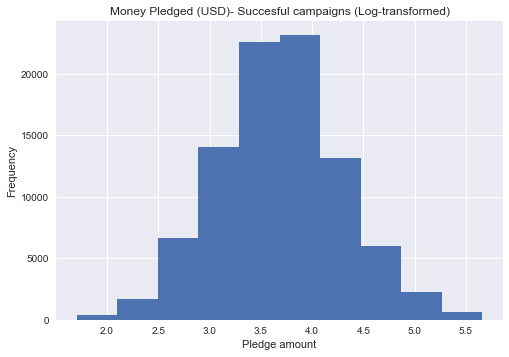

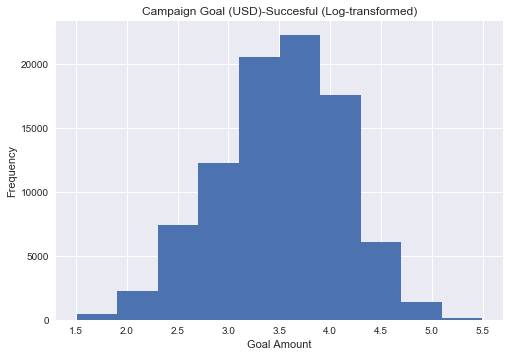

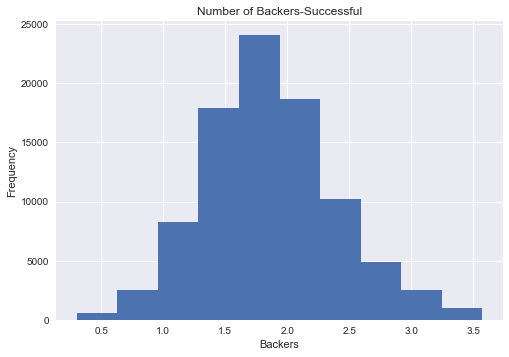

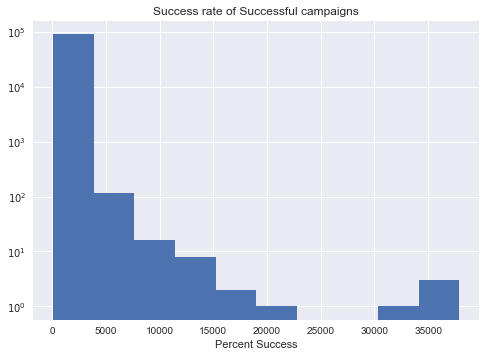

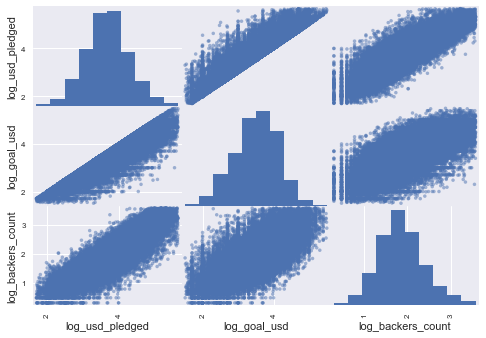

In [184]:
#Exploratory visualization of successful campaigns
pledge_hist_succ=df_successful.hist(column='log_usd_pledged')
plt.xlabel('Pledge amount')
plt.ylabel('Frequency')
plt.title('Money Pledged (USD)- Succesful campaigns (Log-transformed)')


goal_hist_succ=df_successful.hist(column='log_goal_usd')
plt.xlabel('Goal Amount')
plt.ylabel('Frequency')
plt.title('Campaign Goal (USD)-Succesful (Log-transformed)')

backers_hist_succ=df_successful.hist(column='log_backers_count')
plt.xlabel('Backers')
plt.ylabel('Frequency')
plt.title('Number of Backers-Successful')

percent_succ=df_successful.hist(column='percent success', log=True)
plt.xlabel('Percent Success')
plt.title('Success rate of Successful campaigns')

scat_succ=pd.plotting.scatter_matrix(df_successful[['log_usd_pledged','log_goal_usd','log_backers_count']])

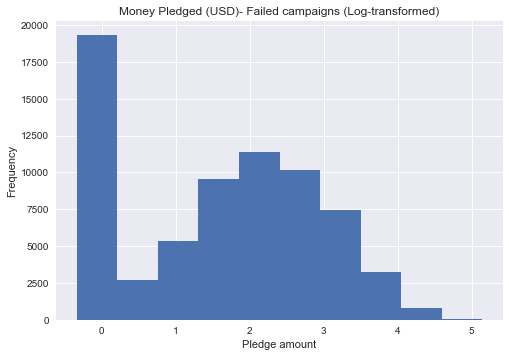

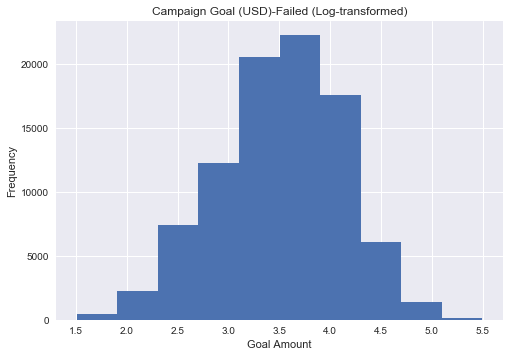

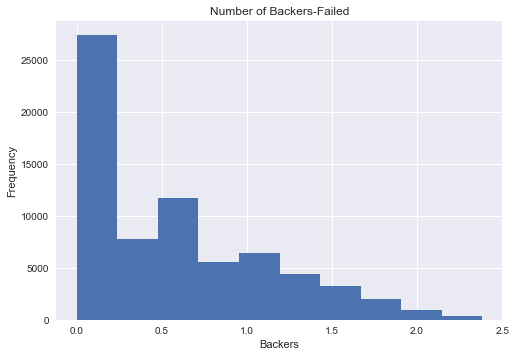

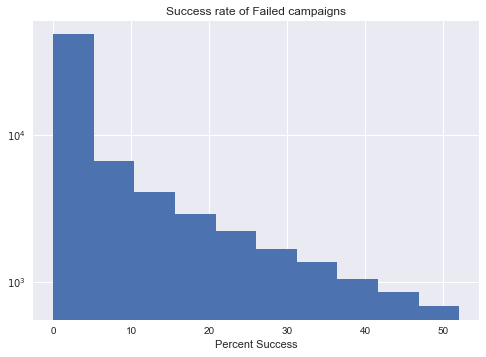

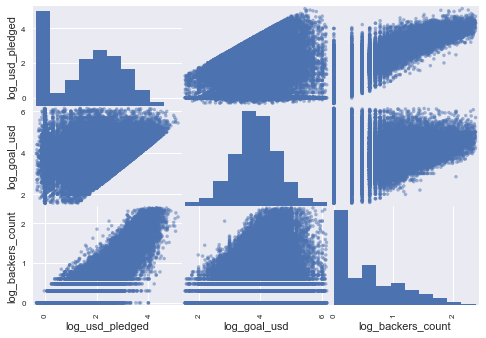

In [185]:
#Exploratory visualization of failed campaign data
pledge_hist_fail=df_failed.hist(column='log_usd_pledged')
plt.xlabel('Pledge amount')
plt.ylabel('Frequency')
plt.title('Money Pledged (USD)- Failed campaigns (Log-transformed)')


goal_hist_fail=df_successful.hist(column='log_goal_usd')
plt.xlabel('Goal Amount')
plt.ylabel('Frequency')
plt.title('Campaign Goal (USD)-Failed (Log-transformed)')

backers_hist_fail=df_failed.hist(column='log_backers_count')
plt.xlabel('Backers')
plt.ylabel('Frequency')
plt.title('Number of Backers-Failed')

percent_fail=df_failed.hist(column='percent success', log=True)
plt.xlabel('Percent Success')
plt.title('Success rate of Failed campaigns')



scat_fail=pd.plotting.scatter_matrix(df_failed[['log_usd_pledged','log_goal_usd','log_backers_count']])

Creating pie charts allow us to quickly compare different categories qualitiatively–we can immediately see that among successful campaigns, music is the most common campaign, and among failed campaigns, technology is the most common.

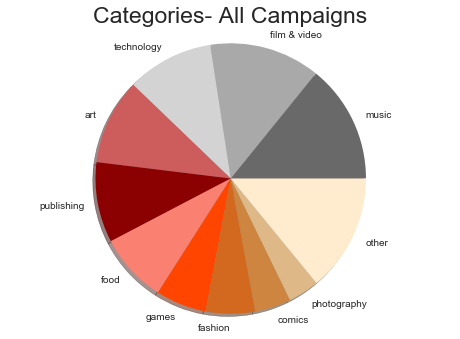

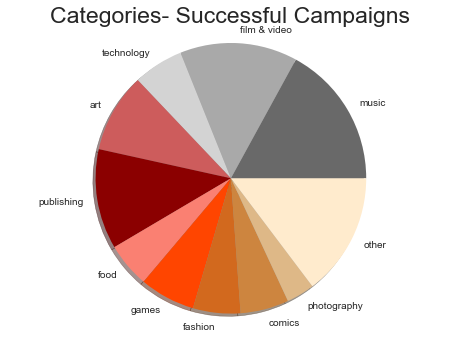

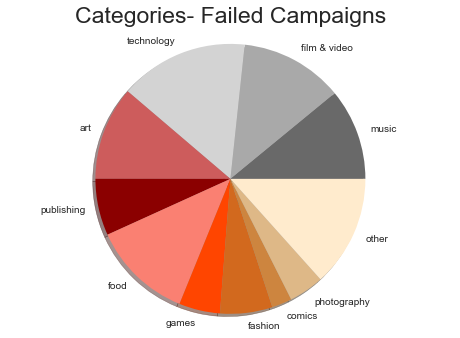

In [187]:
#Pie Chart - All Campaigns
labels = 'music', 'film & video', 'technology', 'art', 'publishing', 'food', 'games', 'fashion', 'comics', 'photography', 'other'
colors = ['dimgray', 'darkgrey', 'lightgrey', 'indianred', 'darkred', 'salmon', 'orangered', 'chocolate', 'peru', 'burlywood', 'blanchedalmond']
sizes = [23386, 21893, 17167, 16912, 15873, 13679, 10015, 9727, 7118, 6110, (5861+5653+5020+3781+2923)];
explode = (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
plt.pie(sizes, labels=labels,colors = colors, explode=explode, shadow=True);  
plt.axis('equal')
plt.title('Categories- All Campaigns', fontdict= {"fontsize": 23})
plt.show()
df_successful['gencat'].value_counts()

#Pie Chart- Succesful Campaigns
labels = 'music', 'film & video', 'technology', 'art', 'publishing', 'food', 'games', 'fashion', 'comics', 'photography', 'other'
colors = ['dimgray', 'darkgrey', 'lightgrey', 'indianred', 'darkred', 'salmon', 'orangered', 'chocolate', 'peru', 'burlywood', 'blanchedalmond']
sizes = [15433, 12723, 5446, 8571, 10835, 4842, 6018, 5130, 5242, 3044, (4417+3575+2330+2026+986)];
explode = (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
plt.pie(sizes, labels=labels,colors = colors, explode=explode, shadow=True);  
plt.axis('equal')
plt.title('Categories- Successful Campaigns', fontdict= {"fontsize": 23})
plt.show()

#Pie Chart- Failed Campaigns
labels = 'music', 'film & video', 'technology', 'art', 'publishing', 'food', 'games', 'fashion', 'comics', 'photography', 'other'
colors = ['dimgray', 'darkgrey', 'lightgrey', 'indianred', 'darkred', 'salmon', 'orangered', 'chocolate', 'peru', 'burlywood', 'blanchedalmond']
df_failed['gencat'].value_counts()
sizes = [7655, 8647, 10810, 7853, 4753, 8435, 3440, 4381, 1683, 2937, (573+1364+1839+2731+2844)];
explode = (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
plt.pie(sizes, labels=labels,colors = colors, explode=explode, shadow=True);  
plt.axis('equal')
plt.title('Categories- Failed Campaigns', fontdict= {"fontsize": 23})
plt.show()

But if we want to have a more quantitative understanding of category popularity, it might make more sense to represent this information in a bar graph form. The bar graphs below includes categorizations that were classified as "other" on the pie chart for the sake of readability.

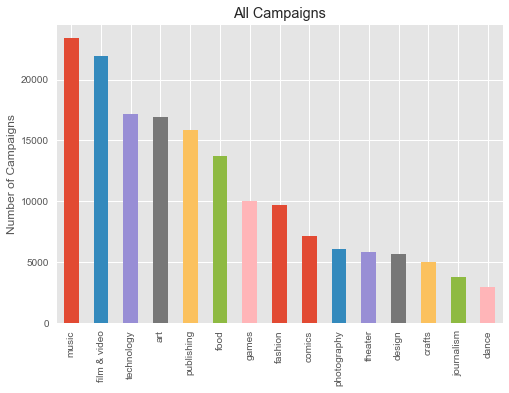

In [212]:
catNum = df['gencat'].value_counts()
plt0 = catNum.plot(title='All Campaigns',kind='bar')
plt0.set_ylabel('Number of Campaigns')

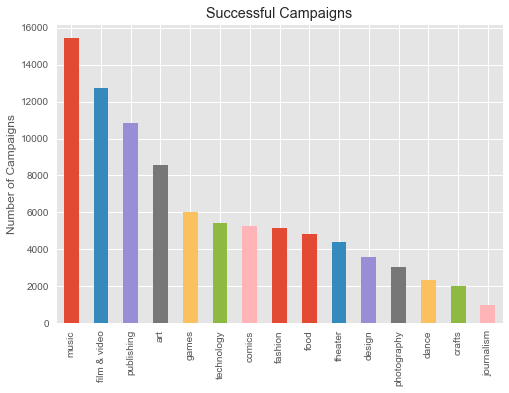

In [213]:
catNum = df_successful['gencat'].value_counts()
plt1 = catNum.plot(title='Successful Campaigns',kind='bar')
plt1.set_ylabel('Number of Campaigns')

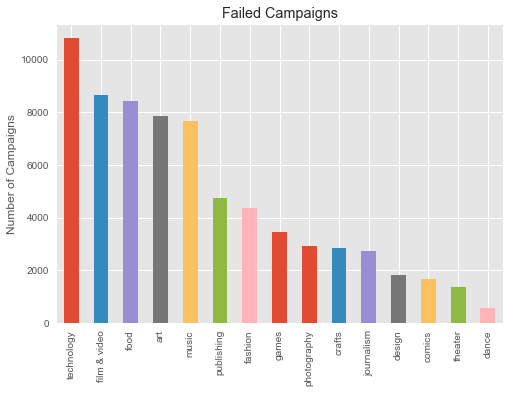

In [214]:
catNum = df_failed['gencat'].value_counts()
plt2 = catNum.plot(title='Failed Campaigns',kind='bar')
plt2.set_ylabel('Number of Campaigns')

As visually apparent, some categories like food and music have higher incidences in one outcome compared to the other, suggesting some (but not overwhelming promise) that category might be a useful feature.

In the line graph below, note a sharp increase in failed campaigns over recent years. As the Kickstarter platform became more popular in general, there was a surprising trend towards campaigns not being as successful. Does a bigger market suggest a more competitive market?

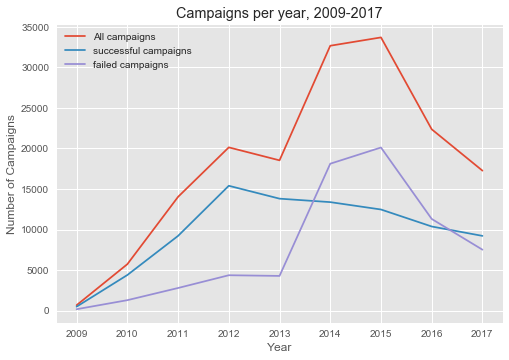

In [189]:
#Number of projects per year
df['campaignYear'] = df['created_at'].apply(convert_time_year)#(sort=False)
#df['campaignYear'].value_counts()
year=[2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017]
camps=[668, 5726, 14034, 20138, 18537, 32676, 33704, 22369, 17265]
plt.plot(year, camps, label='All campaigns')
plt.xlabel('Year')
plt.ylabel('Number of Campaigns')

#Number of successful projects per year
df_successful['campaignYear']=df_successful['created_at'].apply(convert_time_year)
df_successful['campaignYear'].value_counts()
camps_succ=[485, 4389, 9217, 15399, 13810, 13382, 12472, 10376, 9217]
plt.plot(year, camps_succ, label='successful campaigns')
plt.xlabel('Year')
plt.ylabel('Number of Campaigns')

#Number of failed projects per year
df_failed['campaignYear']=df_failed['created_at'].apply(convert_time_year)
df_failed['campaignYear'].value_counts()
camps_fail=[170, 1285, 2787, 4362, 4277, 18122, 20120, 11307, 7515]
plt.plot(year, camps_fail, label='failed campaigns')
plt.title('Campaigns per year, 2009-2017')
plt.xlabel('Year')
plt.ylabel('Number of Campaigns')
plt.legend()

<h2><center>Data Analysis II: Classfication Algorithm</center></h2>

The above visualization and data analysis gave initial encouragement and discouragement to our hypothesis. Category seemed somewhat different for each outcome (failed or successful), which motivated a turn to the subcategory level. Goal seemed worth exploring as it had a peculiar pattern--correlating highly with dollars pledged but not with percent success.

To construct our classifier, our data needs to be partitioned into a training set for the classifier to learn from and set parameter weights for optimal classification, a validation set to set hyperparameters (regularization constant in this case), and a test set to measure performance against data unseen by the classifier.

Each set is picked by randomly sampling the data without replacement. The training set will contain 80% of the failed campaigns and an equal number of succesful campaigns so there is the same number of each label in it. The validation set will contain 10% of the failed campaigns and an equal number of succesful campaigns. The test set will contain the remaining data.

In [28]:
#Partition data into training, validation, and test sets

#Training set size: 80%*min(num failed campaigns, num successful campaigns)
partition = 0.80
trainSize = int(partition*min(len(df_fail),len(df_success)))

#select points randomly from each of the fail, success dataframes and concat
#remaining used for validation and test sets
trainSetFail = df_fail.sample(n=trainSize,axis=0) 
trainSetSucc = df_success.sample(n=trainSize,axis=0)
trainSet = pd.concat([trainSetFail,trainSetSucc])

remainingFail = df_fail[~df_fail.index.isin(trainSetFail.index)]
remainingSucc = df_success[~df_success.index.isin(trainSetSucc.index)]


#construct validation set (10% of total data points)
validSetFail = remainingFail.sample(n=trainSize//8,axis=0)
validSetSucc = remainingSucc.sample(n=trainSize//8,axis=0)
validSet = pd.concat([validSetFail,validSetSucc])

#construct test set (unused points are ~10% of total data points)
testSetFail = remainingFail[~remainingFail.index.isin(validSetFail.index)]
testSetSucc = remainingSucc[~remainingSucc.index.isin(validSetSucc.index)]
testSet = pd.concat([testSetFail,testSetSucc])

We then featurize our data with the following function 'featurize().' We included the following features: the project's (sub)category, country of project, funding goal, days taken to make campaign page, days taken for fundraising campaign itself, whether it was labelled a staff pick or not, the day of the week and month the project was launched on, and the TF-IDF representation of the project's description.

Because a combination of numerical values and one-hot encoding was used as features, feature scaling was important so that parameter weights and regularization were not skewed by the increased. Several feature scaling methods were tried, with the one yielding the most accuracy (whiten) being used.

In [123]:
#extract features fn
#featurize training and validation sets

#TF-IDF analysis of campaign blurbs
tfidf = TfidfVectorizer(sublinear_tf=True,analyzer='word',max_features=200,tokenizer=word_tokenize)
tfidf.fit(trainSet['blurb'])

#list of unique categories to reference during feature extraction

cats = df['category'].unique()

#list of unique locations (countries) to reference during feature extraction
locs = df['location'].apply(lambda x: x[0])
locs = locs.unique()

#i is a row in a given df; index is its index
def featurize(i):
    #categories (one-hot encoded list)
    categories = [0 for i in range(len(cats))]
    for j,c in enumerate(cats):
        if c == i['category']:
            categories[j] = 1
            break
    
    #goal (numeric)
    goal = i['goal_usd']
    
    #campaign length (numeric, days)
    campaignLength = i['deadline'] - i['launched_at']
    campaignLength = campaignLength/(60*60*24) 
    
    #time making campaign (numeric, days)
    campaignPrep = i['launched_at'] - i['created_at']
    campaignPrep = campaignPrep/(60*60*24)
    
    #staff pick (one-hot encoded value)
    isStaffPick = int(i['staff_pick'] == True)
    
    
    #dttm = datetime.datetime.strptime(i['std_launched_at'],'%m-%d-%Y %H:%M:%S')
    #dttm = datetime.datetime.fromtimestamp(i['launched_at'])
    dttm = i['std_launched_at']

    #day of week of launch (one-hot encoded list)
    dayList = [0 for i in range(7)] 
    dayLaunch = dttm.weekday()
    dayList[dayLaunch] = 1
    
    #month of launch (one-hot encoded list)
    monthList = [0 for i in range(12)]
    monthLaunch = dttm.month
    monthList[monthLaunch-1] = 1
    
    #text mining the blurb combined with name
    textFeats = tfidf.transform([i['blurb']]).toarray()[0]
    
    #location (one-hot encoded list of countries)
    locations = [0 for i in range(len(locs))]
    for j,l in enumerate(locs):
        if l == i['location'][0]:
            locations[j] = 1
            break
    
    #return [goal,campaignLength,campaignPrep,isStaffPick,location]+dayList+monthList+categories
    return [goal,campaignPrep,campaignLength,isStaffPick]+categories+dayList+monthList+locations+list(textFeats)
    #return [goal,campaignLength,campaignPrep,campaignLength,isStaffPick]+categories+dayList+monthList+locations

X_train = [featurize(i) for index,i in trainSet.iterrows()]
#X_train = preprocessing.normalize(X_train)
#X_train = preprocessing.scale(X_train)
X_train = whiten(X_train)
print("Featurizing and Normalizing Training Set: Done")

X_valid = [featurize(i) for index,i in validSet.iterrows()]
#X_valid = preprocessing.normalize(X_valid)
#X_valid = preprocessing.scale(X_valid)
X_valid = whiten(X_valid)
print("Featurizing and Normalizing Validation Set: Done")

Next, SVM and Logistic Regression classifiers were trained on the featurized training data. They were also tested against the validation set in order to set the best regularization constant to avoid overfitting while maximizing accuracy on the data the classifiers had seen already.

After running each of these classifiers, the best one was chosen based on validation set accuracy to be used on the test data.

In [116]:
#set up SVM and find best regularization constant
y_train = [i['state'] for index,i in trainSet.iterrows()]
y_valid = [i['state'] for index,i in validSet.iterrows()]

cValues = [0.01,0.1,1,10,100]
#cValues = [0.01]
bestConstantSVM = 0
bestAccuracyValidSVM = 0
bestAccuracyTrainSVM = 0
bestTrainPredSVM = []
bestValidPredSVM = []
bestSVM = 0
for c in cValues:
    clf = svm.LinearSVC(C=c)
    clf.fit(X_train, y_train)
    train_predictions = clf.predict(X_train)
    trainMatch = [ (x==y) for x,y in zip(y_train, train_predictions)]
    trainAccuracy = sum(trainMatch)*1.0/len(trainMatch)
    valid_predictions = clf.predict(X_valid)
    validMatch = [ (x==y) for x,y in zip(y_valid, valid_predictions)]
    validAccuracy = sum(validMatch)*1.0/len(validMatch)
    if validAccuracy > bestAccuracyValidSVM:
        bestConstantSVM = c
        bestAccuracyValidSVM = validAccuracy
        bestAccuracyTrainSVM = trainAccuracy
        bestValidPredSVM = valid_predictions
        bestTrainPredSVM = train_predictions
        bestSVM = clf
    print("Done with",c)
print("Best Regularization Parameter:",bestConstantSVM)
print("Training Set Accuracy:",bestAccuracyTrainSVM)
print("Validation Set Accuracy:",bestAccuracyValidSVM)
print(classification_report(y_valid,bestValidPredSVM))

Done with 0.01
Done with 0.1
Done with 1
Done with 10
Done with 100
Best Regularization Parameter: 0.1
Training Set Accuracy: 0.7951092933736597
Validation Set Accuracy: 0.7959857025020621
             precision    recall  f1-score   support

     failed       0.75      0.88      0.81      7274
 successful       0.86      0.71      0.78      7274

avg / total       0.81      0.80      0.79     14548



In [117]:
# Log Reg

cValues = [0.01,0.1,1,10,100]
#cValues = [0.01]
bestConstantLR = 0
bestAccuracyValidLR = 0
bestAccuracyTrainLR = 0
bestTrainPredLR = []
bestValidPredLR = []
bestLR = 0
for c in cValues:
    lr = LogisticRegression(C=c)
    lr.fit(X_train, y_train)
    train_predictions = lr.predict(X_train)
    trainMatch = [ (x==y) for x,y in zip(y_train, train_predictions)]
    trainAccuracy = sum(trainMatch)*1.0/len(trainMatch)
    valid_predictions = lr.predict(X_valid)
    validMatch = [ (x==y) for x,y in zip(y_valid, valid_predictions)]
    validAccuracy = sum(validMatch)*1.0/len(validMatch)
    if validAccuracy > bestAccuracyValidLR:
        bestConstantLR = c
        bestAccuracyValidLR = validAccuracy
        bestAccuracyTrainLR = trainAccuracy
        bestTrainPredLR = train_predictions
        bestValidPredLR = valid_predictions
        bestLR = lr
    print("Done with",c)
print("Best Regularization Parameter:",bestConstantLR)
print("Training Set Accuracy:",bestAccuracyTrainLR)
print("Validation Set Accuracy:",bestAccuracyValidLR)
print(classification_report(y_valid,bestValidPredLR))

Done with 0.01
Done with 0.1
Done with 1
Done with 10
Done with 100
Best Regularization Parameter: 100
Training Set Accuracy: 0.797678375034369
Validation Set Accuracy: 0.7967418201814682
             precision    recall  f1-score   support

     failed       0.76      0.88      0.81      7274
 successful       0.85      0.72      0.78      7274

avg / total       0.80      0.80      0.80     14548



In [118]:
#ensemble (choosing best classifier) and predict on test data
modelChoice = 0
bestTrainPred = []
bestValidPred = []
bestConstant
if bestAccuracyValidLR > bestAccuracyValidSVM:
    bestModel = bestLR
    modelChoice = 1
    bestTrainPred = bestTrainPredLR
    bestTrain = bestAccuracyValidLR
    bestValidPred = bestValidPredLR
    bestValid = bestAccuracyTrainLR 
else:
    bestModel = bestSVM
    modelChoice = 2
    bestTrainPred = bestTrainPredSVM
    bestTrain = bestAccuracyValidSVM
    bestValidPred = bestValidPredSVM
    bestValid = bestAccuracyTrainSVM
print(bestModel)


X_test = [featurize(i) for index,i in testSet.iterrows()]
#X_test = preprocessing.normalize(X_test)
#X_test = preprocessing.scale(X_test)
X_test = whiten(X_test)
y_test = [i['state'] for index,i in testSet.iterrows()]
test_predictions = clf.predict(X_test)
testMatch = [ (x==y) for x,y in zip(y_test, test_predictions)]
testAccuracy = sum(testMatch)*1.0/len(testMatch)
print("Test Set Accuracy:",testAccuracy)

LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


/Users/SR/anaconda/lib/python3.6/site-packages/scipy/cluster/vq.py:148: RuntimeWarning: Some columns have standard deviation zero. The values of these columns will not change.
  RuntimeWarning)


Test Set Accuracy: 0.7394903899599216


Above error can be ignored as it just notifies some columns have no std dev, which the .whiten feature scaling expects. This is due to the TFIDF values with certain words from the training set not appearing in the test set, which could happen in real life application.

For the best model (most accurate combination of classifier and regularization constant), we also produced other performance metrics such as True/False Positive Rate (TPR/FPR), True/False Negative Rate (TNR,FNR), and Balanced Accuracy (0.5*(TPR+TNR)). We arbitrarily defined Positives as Successful campaigns and Negatives as Failed campaigns. We also produced precision and recall for the predictions made on the test set to give a full picture of this model's performance. We treated Balanced Accuracy as our most important performance metric, as we wanted a metric that treats classification of successes and failures equal and takes the number of true succesful and failed campaigns tested on into account. Balanced Accuracy met both of these criterion.

In [119]:
#Performance Metrics:

#TRAINING FPR and FNR
print("Training Set Accuracy:",bestTrain)
TP = sum([ (x=="successful" and y=="successful") for x,y in zip(bestTrainPred,y_train)])
TN = sum([ (x=="failed" and y=="failed") for x,y in zip(bestTrainPred,y_train)])
FP = sum([ (x=="successful" and y=="failed") for x,y in zip(bestTrainPred,y_train)])
FN = sum([ (x=="failed" and y=="successful") for x,y in zip(bestTrainPred,y_train)])
FPR = 100.0*FP/(FP+TN)
FNR = 100.0*FN/(FN+TP)
TPR = 100.0*TP/(TP+FN)
TNR = 100.0*TN/(TN+FP)
#print("Training FPR: {}%".format(FPR))
#print("Training FNR: {}%".format(FNR))
print("Training TPR: {}%".format(TPR))
print("Training TNR: {}%".format(TNR))


#VALIDATION FPR and FNR
print("Validation Set Accuracy:",bestValid)
TP = sum([ (x=="successful" and y=="successful") for x,y in zip(bestValidPred,y_valid)])
TN = sum([ (x=="failed" and y=="failed") for x,y in zip(bestValidPred,y_valid)])
FP = sum([ (x=="successful" and y=="failed") for x,y in zip(bestValidPred,y_valid)])
FN = sum([ (x=="failed" and y=="successful") for x,y in zip(bestValidPred,y_valid)])
FPR = 100.0*FP/(FP+TN)
FNR = 100.0*FN/(FN+TP)
TPR = 100.0*TP/(TP+FN)
TNR = 100.0*TN/(TN+FP)
#print("Validation FPR: {}%".format(FPR))
#print("Validation FNR: {}%".format(FNR))
print("Validation TPR: {}%".format(TPR))
print("Validation TNR: {}%".format(TNR))

#TEST FPR and FNR
TP = sum([ (x=="successful" and y=="successful") for x,y in zip(test_predictions,y_test)])
TN = sum([ (x=="failed" and y=="failed") for x,y in zip(test_predictions,y_test)])
FP = sum([ (x=="successful" and y=="failed") for x,y in zip(test_predictions,y_test)])
FN = sum([ (x=="failed" and y=="successful") for x,y in zip(test_predictions,y_test)])
FPR = 100.0*FP/(FP+TN)
FNR = 100.0*FN/(FN+TP)
TPR = 100.0*TP/(TP+FN)
TNR = 100.0*TN/(TN+FP)
#print("Validation FPR: {}%".format(FPR))
#print("Validation FNR: {}%".format(FNR))
print("Test TPR: {}%".format(TPR))
print("Test TNR: {}%".format(TNR))
print()
print("Balanced Test Accuracy: {}%".format(0.5*(TPR+TNR)))
#print("Balanced Training Accuracy: {}%".format(0.5*))
#print("Balanced Training Accuracy: {}%".format(0.5*))
print()
print(classification_report(y_test,test_predictions))

Training Set Accuracy: 0.7967418201814682
Training TPR: 71.8981990651636%
Training TNR: 87.6374759417102%
Validation Set Accuracy: 0.797678375034369
Validation TPR: 71.74869397855376%
Validation TNR: 87.5996700577399%
Test TPR: 75.99316213906128%
Test TNR: 66.38713225185593%

Balanced Test Accuracy: 71.19014719545861%

             precision    recall  f1-score   support

     failed       0.43      0.66      0.52      7274
 successful       0.89      0.76      0.82     26909

avg / total       0.79      0.74      0.76     34183



Balanced Accuracy on the test set is 71 percent. An interesting observation from the above performance metrics is that the classifier is better at accurately detecting successful or failed campaigns depending on the set of data it is making predictions on. This motivated us to run the above process not just on one instance of randomly sampling the data into test, validation, and training sets but on multiple trials to obtain an average result to gain a better picture of our algorithm's performance. Thus, we repeated the above classifier training and testing process 9 more times, as seen with the following code.

In [124]:
numIter = 9 #10th iteration already occurred
trainBalancedAccuracies = []
validBalancedAccuracies = []
testBalancedAccuracies = []

#TF-IDF analysis of campaign blurbs
tfidf = TfidfVectorizer(sublinear_tf=True,analyzer='word',max_features=200,tokenizer=word_tokenize)
tfidf.fit(trainSet['blurb'])

#list of unique categories to reference during feature extraction
cats = df['category'].unique()

#list of unique locations (countries) to reference during feature extraction
locs = df['location'].apply(lambda x: x[0])
locs = locs.unique()

for counter in range(numIter):
    partition = 0.80
    trainSize = int(partition*min(len(df_fail),len(df_success)))

    #select points randomly from each of the fail, success dataframes and concat
    #remaining used for validation and test sets
    trainSetFail = df_fail.sample(n=trainSize,axis=0) 
    trainSetSucc = df_success.sample(n=trainSize,axis=0)
    trainSet = pd.concat([trainSetFail,trainSetSucc])

    remainingFail = df_fail[~df_fail.index.isin(trainSetFail.index)]
    remainingSucc = df_success[~df_success.index.isin(trainSetSucc.index)]


    #construct validation set (10% of total data points)
    validSetFail = remainingFail.sample(n=trainSize//8,axis=0)
    validSetSucc = remainingSucc.sample(n=trainSize//8,axis=0)
    validSet = pd.concat([validSetFail,validSetSucc])

    #construct test set (unused points are ~10% of total data points)
    testSetFail = remainingFail[~remainingFail.index.isin(validSetFail.index)]
    testSetSucc = remainingSucc[~remainingSucc.index.isin(validSetSucc.index)]
    testSet = pd.concat([testSetFail,testSetSucc])
    
    X_train = [featurize(i) for index,i in trainSet.iterrows()]
    #X_train = preprocessing.normalize(X_train)
    #X_train = preprocessing.scale(X_train)
    X_train = whiten(X_train)
    print("Featurizing and Normalizing Training Set: Done")

    X_valid = [featurize(i) for index,i in validSet.iterrows()]
    #X_valid = preprocessing.normalize(X_valid)
    #X_valid = preprocessing.scale(X_valid)
    X_valid = whiten(X_valid)
    print("Featurizing and Normalizing Validation Set: Done")
    
    y_train = [i['state'] for index,i in trainSet.iterrows()]
    y_valid = [i['state'] for index,i in validSet.iterrows()]

    cValues = [0.01,0.1,1,10,100]
    #cValues = bestConstant
    #cValues = [0.01]
    bestConstantSVM = 0
    bestAccuracyValidSVM = 0
    bestAccuracyTrainSVM = 0
    bestTrainPredSVM = []
    bestValidPredSVM = []
    bestSVM = 0
    for c in cValues:
        clf = svm.LinearSVC(C=c)
        clf.fit(X_train, y_train)
        train_predictions = clf.predict(X_train)
        trainMatch = [ (x==y) for x,y in zip(y_train, train_predictions)]
        trainAccuracy = sum(trainMatch)*1.0/len(trainMatch)
        valid_predictions = clf.predict(X_valid)
        validMatch = [ (x==y) for x,y in zip(y_valid, valid_predictions)]
        validAccuracy = sum(validMatch)*1.0/len(validMatch)
        if validAccuracy > bestAccuracyValidSVM:
            bestConstantSVM = c
            bestAccuracyValidSVM = validAccuracy
            bestAccuracyTrainSVM = trainAccuracy
            bestValidPredSVM = valid_predictions
            bestTrainPredSVM = train_predictions
            bestSVM = clf

    bestConstantLR = 0
    bestAccuracyValidLR = 0
    bestAccuracyTrainLR = 0
    bestTrainPredLR = []
    bestValidPredLR = []
    bestLR = 0
    for c in cValues:
        lr = LogisticRegression(C=c)
        lr.fit(X_train, y_train)
        train_predictions = lr.predict(X_train)
        trainMatch = [ (x==y) for x,y in zip(y_train, train_predictions)]
        trainAccuracy = sum(trainMatch)*1.0/len(trainMatch)
        valid_predictions = lr.predict(X_valid)
        validMatch = [ (x==y) for x,y in zip(y_valid, valid_predictions)]
        validAccuracy = sum(validMatch)*1.0/len(validMatch)
        if validAccuracy > bestAccuracyValidLR:
            bestConstantLR = c
            bestAccuracyValidLR = validAccuracy
            bestAccuracyTrainLR = trainAccuracy
            bestTrainPredLR = train_predictions
            bestValidPredLR = valid_predictions
            bestLR = lr
            
    modelChoice = 0
    bestTrainPred = []
    bestValidPred = []
    if bestAccuracyValidLR > bestAccuracyValidSVM:
        bestModel = bestLR
        modelChoice = 1
        bestTrainPred = bestTrainPredLR
        bestTrain = bestAccuracyValidLR
        bestValidPred = bestValidPredLR
        bestValid = bestAccuracyTrainLR 
    else:
        bestModel = bestSVM
        modelChoice = 2
        bestTrainPred = bestTrainPredSVM
        bestTrain = bestAccuracyValidSVM
        bestValidPred = bestValidPredSVM
        bestValid = bestAccuracyTrainSVM
    print(bestModel)


    X_test = [featurize(i) for index,i in testSet.iterrows()]
    #X_test = preprocessing.normalize(X_test)
    #X_test = preprocessing.scale(X_test)
    X_test = whiten(X_test)
    y_test = [i['state'] for index,i in testSet.iterrows()]
    test_predictions = clf.predict(X_test)
    testMatch = [ (x==y) for x,y in zip(y_test, test_predictions)]
    
    TP = sum([ (x=="successful" and y=="successful") for x,y in zip(bestTrainPred,y_train)])
    TN = sum([ (x=="failed" and y=="failed") for x,y in zip(bestTrainPred,y_train)])
    FP = sum([ (x=="successful" and y=="failed") for x,y in zip(bestTrainPred,y_train)])
    FN = sum([ (x=="failed" and y=="successful") for x,y in zip(bestTrainPred,y_train)])
    FPR = 100.0*FP/(FP+TN)
    FNR = 100.0*FN/(FN+TP)
    TPR = 100.0*TP/(TP+FN)
    TNR = 100.0*TN/(TN+FP)
    balancedAccuracy = 0.5*(TPR+TNR)
    trainBalancedAccuracies.append(balancedAccuracy)
        
    TP = sum([ (x=="successful" and y=="successful") for x,y in zip(bestValidPred,y_valid)])
    TN = sum([ (x=="failed" and y=="failed") for x,y in zip(bestValidPred,y_valid)])
    FP = sum([ (x=="successful" and y=="failed") for x,y in zip(bestValidPred,y_valid)])
    FN = sum([ (x=="failed" and y=="successful") for x,y in zip(bestValidPred,y_valid)])
    FPR = 100.0*FP/(FP+TN)
    FNR = 100.0*FN/(FN+TP)
    TPR = 100.0*TP/(TP+FN)
    TNR = 100.0*TN/(TN+FP)
    balancedAccuracy = 0.5*(TPR+TNR)
    validBalancedAccuracies.append(balancedAccuracy)

    TP = sum([ (x=="successful" and y=="successful") for x,y in zip(test_predictions,y_test)])
    TN = sum([ (x=="failed" and y=="failed") for x,y in zip(test_predictions,y_test)])
    FP = sum([ (x=="successful" and y=="failed") for x,y in zip(test_predictions,y_test)])
    FN = sum([ (x=="failed" and y=="successful") for x,y in zip(test_predictions,y_test)])
    FPR = 100.0*FP/(FP+TN)
    FNR = 100.0*FN/(FN+TP)
    TPR = 100.0*TP/(TP+FN)
    TNR = 100.0*TN/(TN+FP)
    balancedAccuracy = 0.5*(TPR+TNR)
    testBalancedAccuracies.append(balancedAccuracy)

Featurizing and Normalizing Training Set: Done
Featurizing and Normalizing Validation Set: Done
LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Featurizing and Normalizing Training Set: Done
Featurizing and Normalizing Validation Set: Done
LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
Featurizing and Normalizing Training Set: Done
Featurizing and Normalizing Validation Set: Done
LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_stat

The above output displays how generally, but not always, a logistic regression with a regularization constant around 1 is the best combination for a classifier on this data. Future steps should include more than 9 iterations to determine this more precisely. We ran 9 iterations as the classification process took significant time and sometimes led to freezes when running even 1 iteration on our personal machines.

Using our chosen performance metric to focus on, Balanced Accuracy, the subsequent 9 iterations of resampling the data and running the classification algorithms on them yielded the following results:

In [127]:
avrTrainBalancedAccuracy = sum(trainBalancedAccuracies)/len(trainBalancedAccuracies)
avrValidBalancedAccuracy = sum(validBalancedAccuracies)/len(validBalancedAccuracies)
avrTestBalancedAccuracy = sum(testBalancedAccuracies)/len(testBalancedAccuracies)
print("Average Training Set Balanced Accuracy: {}%".format(avrTrainBalancedAccuracy),end=' ')
print("+/-",pd.Series(trainBalancedAccuracies).std(),"(1 standard deviation)")
print("Average Validation Set Balanced Accuracy: {}%".format(avrValidBalancedAccuracy),end=' ')
print("+/-",pd.Series(validBalancedAccuracies).std(),"(1 standard deviation)")
print("Average Test Set Balanced Accuracy: {}%".format(avrTestBalancedAccuracy),end=' ')
print("+/-",pd.Series(testBalancedAccuracies).std(),"(1 standard deviation)")

Average Training Set Balanced Accuracy: 80.32805196590597% +/- 0.13604676470269095 (1 standard deviation)
Average Validation Set Balanced Accuracy: 80.12861638102221% +/- 0.2938185336249758 (1 standard deviation)
Average Test Set Balanced Accuracy: 72.26434493114257% +/- 0.7082935641413134 (1 standard deviation)


Thus, we arrive at our core result for this investigation. We report a Balanced Accuracy on our test set, data our algorithm never trained on, as 72.26 percent with a standard deviation of 0.7%. This relatively low standard deviation and the relative closeness of the test set accuracy to the other sets' accuries suggest that overfitting was limmited and that this performance can be reliably expected on other samplings of the data or future data for campaigns that have not concluded yet (barring significant changes to Kickstarter project or patron base).

We also ran 9 other iterations and received a higher average test set balanced accuracy with very similar training and validation accuracies (displayed below). Since this means the partition choice can still cause substantial variation,  more iterations must be run in order to improve the precision of our ability to report classifier accuracy. An interesting observation is that the training and validation sets are extremely similar and that the test set accuracies are more different, suggesting that the accuracy upper limit on the classifier as is might be 80% and is achievable by the test set. These second set of 9 iterations also indicate minimal overfitting as test and training set accuracies were very similar.

In [104]:
avrTrainBalancedAccuracy = sum(trainBalancedAccuracies)/len(trainBalancedAccuracies)
avrValidBalancedAccuracy = sum(validBalancedAccuracies)/len(validBalancedAccuracies)
avrTestBalancedAccuracy = sum(testBalancedAccuracies)/len(testBalancedAccuracies)
print("Average Training Set Balanced Accuracy: {}%".format(avrTrainBalancedAccuracy),end=' ')
print("+/-",pd.Series(trainBalancedAccuracies).std(),"(1 standard deviation)")
print("Average Validation Set Balanced Accuracy: {}%".format(avrValidBalancedAccuracy),end=' ')
print("+/-",pd.Series(validBalancedAccuracies).std(),"(1 standard deviation)")
print("Average Test Set Balanced Accuracy: {}%".format(avrTestBalancedAccuracy),end=' ')
print("+/-",pd.Series(testBalancedAccuracies).std(),"(1 standard deviation)")

Average Training Set Balanced Accuracy: 80.13138499373721% +/- 0.05768726391117881 (1 standard deviation)
Average Validation Set Balanced Accuracy: 79.92774875507898% +/- 0.3292513725244061 (1 standard deviation)
Average Test Set Balanced Accuracy: 79.46003579693439% +/- 0.15109765386086513 (1 standard deviation)


Lastly, we wanted to analyze which features were most important to the classification. Thus, we took the last iteration's best classifier and looked at its coefficents vector. We paired it with its index position in that vector so it correlates to the same position in the feature vector and we can find which features had the highest weights.

In [141]:
#weights analysis
weights = [(i,index) for index,i in enumerate(bestModel.coef_[0])]
sortedWeights = sorted(weights,key=lambda pair: abs(pair[0]))
sortedWeights.reverse()
print(sortedWeights[0:10])
print("Number of category features:",len(cats))

[(-7.372053230291949, 0), (1.0417858861551552, 95), (0.7603910613574977, 59), (0.7581167105172018, 133), (0.7453987261912589, 111), (0.7451759171266501, 112), (0.7447608082752212, 166), (0.7433919514772788, 93), (0.7423265895683975, 60), (0.7355691066200147, 107)]
Number of category features: 169


In [147]:
#importances of campaignPrep,campaignLength,isStaffPick (in that order)
weights[2:5]

[(0.05257676357098189, 2), (-0.16954274772179295, 3), (0.6678917188682884, 4)]

The above 2 cells of output is a list of the top 10 most important features, represented as (absolute value of weight,index) pairs, followed by the weights placed on the first five features in the feature vector(in order: goal,campaignLength,campaignPrep,campaignLength,isStaffPick). The first and most important feature is at position 0 in the feature vector, which is the goal amount. With the observation that there are 169 (sub)categories, the remaining top 9 features are all (sub)categories. isStaffPick is also relatively important, though less important than several (sub)categories. Thus, this answers a core part of our investigation--funding goal and the (sub)category are most important in determining outcome of a project, with low goals and the indicated 9 categories being indicative of success.

The next 3 most important features (the most important categories) are listed below.

In [148]:
print(cats[95-5])
print(cats[59-5])
print(cats[133-5])

games/video games
film & video/documentary
publishing/children's books


<h2><center>Privacy and Ethical Considerations</center></h2>

This data was scraped from Kickstarter's website and contains publically available information inputted by the campaign creators. This information includes campaign creators' usernames, Kickstarter profiles, and locations on city-state-country levels. The deliberate inputting of this information by the campaign creators would suggest that they are comfortable with this information being public; however, this dataset still highlights the personal nature of this public information and raises the question of whether users should not provide real name and location information on their campaign and user pages to guard against potential privacy breaches. In our data cleaning and preprocessing, we removed username and profile in order to minimize presence and use of this personal information and build a model that worked purely on features of the campaign page. We did include location on the nation level in our analysis, which would abide by the Safe Harbor guidelines. 

The dataset we are working with is comprehensive, collecting data on Kickstarter projects sitewide. To that end, biases imposed by exclusion of particular observations in collecting the data are minimized. We considered potential ethical consequences of our own data pre-processing and exclusion of data points that were incomplete or too extreme (outside the range of mean +/- 3sd). We deemed these measures appropriate, as they were necessary to conduct our analysis and still allowed for the large majority and diverse spectrum of the data to be considered and used, keeping biases or skews in our analysis from pre-processing to a negligible level. 

Finally, as with any predictive tool, their application can be informative but also influence future results and the ethics of this must be considered. For instance, if our results were hypothetically adopted, it could create thresholds and predictions that bias people’s beliefs about certain campaigns’ prospects. As a consequence, the tool would not just be reporting on campaigns’ prospects but affecting them real-time. This is an important ethical consideration of our classifier, the implications and appropriate usage of which we discuss in the next section. 

<h2><center>Conclusion and Discussion</center></h2>

### Summary and Discussion of Results and Baseline Comparison

Our algorithm was able to predict outcome of a campaign with a balanced accuracy that ranged from 72.26 percent to 79.46 percent on a given test set. It also uncovered that the most important predictors of outcome are 1) the funding goal set and 2) the project's (sub)category, which can be 0 to 1 magnitudes less important than funding goal. Successful campaigns tend to have a profile of a low funding goal and are video games, documentaries, or children's books. We suspect that features like day of the week and month of campaign launch were of lower importance because people viewing the page and donating, the driver of success, can occur at any time during the campaign, which lasts for several days. Whether a project was a staff pick or not had a moderate to high level of importance. Campaign length and preparation time likely were not very important and in fact had negative weights probably because campaigns that people delayed in launching after creating or that may have been exorbitant in lifespan may have been not very compelling, passion projects of the creator or of donors that required urgency. Finally, the words from the project descriptions may have been so varied or were specific description or aggrandizing words used by both successful and failed projects that these features were not very valuable. 

To contextualize our accuracy result, we compare against potential naive, baseline approaches to predicing campaign outcome. Specifically, one could just classify all campaigns as whichever outcome is more common in the overall dataset: successful, which makes up about 55.9 percent of the data. This naive approach would obtain a 55.9 percent accuracy. It can also be turned into a probabilitic approach akin to flipping a coin with a 55.9 percent bias for successful, yielding an expected accuracy of 55.9 percent. By comparison, our classifier's accuracy indeed is superior to naive baselines and suggests our efforts on this predictive task were fruitful.

### Implications of Project on Topic Domain

To conclude, we were able to answer our research question and prove our hypothesis true--we were able to uncover which features (funding goal and (sub)category) were most important in predicting outcome of a Kickstarter funding campaign, and we were able to use these features to produce a classifier that was clearly superior to naive baselines. 

This information is useful for not only Kickstarter as a company and manager of this crowdfunding marketplace but also for prospective campaign owners and donors. Knowing what factors are most important and persuasive to potential donors can give project creators a leg-up in designing more successful campaigns and projects. Our results indicate that setting as low a goal as appropriate to the project's needs is critical to success. Additionally, it suggests to project creators that their best chances of success are in categories like video games and children's books and that categories with negative weights face an uphill battle. This provides insight to Kickstarter as well as those who study crowdfunding and consumer preferences as to what products people are most desiring and willing to support over the internet. For Kickstarter as a company, the moderate to high weight placed on the isStaffPick feature demonstrates the "kingmaker" role that they play with this feature of their site. On their site, they claim this pick is to promote especially creative and diverse projects. Our results indicate that these projects are often successful, potentially due to being selected as a staff pick rather than solely their inherent attractiveness. As our ethical considerations section indicates, this knowledge can be abused--Kickstarter could in theory influence their overall number and percent of successful projects (figures they proudly display first on their stats page that we cited) and appear more attractive than their competitors by selecting projects that are just on the cusp of being successful as "staff picks," pushing them over the line. For potential donors, this information could be valuable in informing them whether a project is more likely to succeed or be a failure and merely a temporary allocation of their money. Thus, this predicative algorithm is both informative on donor spending habits and the differences between successful and failed projects and can be wielded by each involved party to advance each of their crowdfunding interests.

### Future Steps

Foremost of future steps for this investigation would be running our classification approach with many more iterations to gain a more precise sense of expected accuracy. Additionally, we would explore inclusion of other features that were not present in this dataset through scraping the webpages ourselves. For instance, a critical feature of kickstarter campaigns is the tiered reward system in exchange for specificed levels of donation. Including features like number of levels, spacing between the levels, and text mining to appraise the value of the reward (words like "personalized" or "in-person" might indicate high-value, unique rewards) could lead to a more accurate classifier and the opportunity to better understand optimal and sub-optimal tiers of the reward system. Finally, it would be of value to obtain a time series of the campaigns' pledged funds over its lifetime. This would enable analysis of factors like virality/explosiveness of the project based on how quickly it raised funds during the first x% of its lifespan or on average.

<h2><center>Works Cited</center></h2>

Barnett, Chance. "Trends Show Crowdfunding To Surpass VC In 2016." Forbes, 9 June 2015. 
    https://www.forbes.com/sites/chancebarnett/2015/06/09/trends-show-crowdfunding-to-surpass-vc-in2016/#6291d0974547.

"Kickstarter Stats." Kickstarter, Updated 21 March 2018. https://www.kickstarter.com/help/stats.

Tanushree, Mitra and Gilbert, Eric. "The Language that Gets People to Give: Phrases that Predict Success on 
    Kickstarter." Proceedings of the 17th ACM conference on Computer Supported Cooperative Work and Social Computing, 
    February 15-19, 2014, Baltimore, Maryland, USA. 
    https://pdfs.semanticscholar.org/feee/c5240e86e914d87356b34210569526bf0a74.pdf